In [16]:
#Loading required packages
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
from sklearn.ensemble import RandomForestRegressor, RandomTreesEmbedding, RandomForestClassifier
import holidays
from datetime import date, timedelta
import seaborn as sns
%matplotlib inline
# setting random seed
np.random.seed(1)
import warnings
warnings.filterwarnings('ignore')

#  I have divided the calculated Labour by 7  hours. Let's say 1 hours is spent on break and other adhoc things

In [17]:
# Loading datasets

df_out = pd.read_excel('Daily outbound.xlsx')

print(df_out.columns)
# Parse the 'Date' column as a datetime object
df_out['Processed_date'] = pd.to_datetime(df_out['Processed_date'])
# Create a mask for rows with Processed_date less than '2022-08-01'
mask = df_out['Processed_date'] < '2022-08-01'

# Drop rows based on the mask
df_out = df_out[~mask]
# Display the first few rows of the DataFrame
print(df_out.head())




Index(['Processed_date', 'Weekday', 'Year', 'Week_number', 'No of Colli',
       'No of Pallet', 'Qty Actual', 'Qty actual OSR', 'FC OSR', 'SU OSR',
       'Qty actual manual', 'FC Manual', 'SU Manual ', 'FC pick ORS',
       'SU pick OSR hour', 'FC pick Manual hour', 'SU pick Manual hour',
       'Palletizing Rate', 'Pallet Wrapping Rate', 'Total Hour',
       'Calculated Labour', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23',
       'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26'],
      dtype='object')
   Processed_date Weekday  Year  Week_number  No of Colli  No of Pallet  \
82     2022-08-01     Mon  2022           31         3167            74   
83     2022-08-02     Tue  2022           31         2387            98   
84     2022-08-03     Wed  2022           31         1691           200   
85     2022-08-04     Thu  2022           31         1964           129   
86     2022-08-05     Fri  2022           31         2327            84   

    Qty Actual  Qty actual OSR  FC OSR  SU O

In [18]:
df_in = pd.read_excel('Daily inbound.xlsx')
print(df_in.columns)

# Parse the 'Date' column as a datetime object
df_in['date'] = pd.to_datetime(df_in['date'])

# Display the first few rows of the DataFrame
print(df_in.head())

Index(['date', 'Week number', 'Weekday', 'Year', 'No of Pallets Inbound ',
       ' No of Pallets InboundFrigo ', 'Total inbound Pallets',
       'Number of Batches', 'Loading and unloading', 'Inbound desk',
       'Inbound Floor', 'Packing check', 'Infeed', 'Interanal transport',
       'Depalletizing (auto + manual)\n', 'Manual Replenishment', 'Minutes',
       'Hour', 'Calculated Labour', 'Unnamed: 19', 'Tasks for Inbound\n',
       'TIME per pallet/batch', 'MEANING'],
      dtype='object')
        date  Week number Weekday  Year  No of Pallets Inbound   \
0 2022-08-01           31     Mon  2022                     156   
1 2022-08-02           31     Tue  2022                     126   
2 2022-08-03           31     Wed  2022                     176   
3 2022-08-04           31     Thu  2022                     148   
4 2022-08-05           31     Fri  2022                     172   

    No of Pallets InboundFrigo   Total inbound Pallets  Number of Batches  \
0                    

#  Subset selection of  columns to work with

In [19]:
select_in = ['date','No of Pallets Inbound ', ' No of Pallets InboundFrigo ',  'Number of Batches','Calculated Labour']
subset_in = df_in[select_in]
subset_in.head()

,date,No of Pallets Inbound,No of Pallets InboundFrigo,Number of Batches,Calculated Labour
0,2022-08-01,156,0,30,3.777922
1,2022-08-02,126,1,50,4.598052
2,2022-08-03,176,33,20,3.859524
3,2022-08-04,148,31,63,6.035931
4,2022-08-05,172,58,55,6.211039


In [20]:
select_out = ['Processed_date','No of Colli',  'No of Pallet','SU OSR', 'SU Manual ','FC Manual','Calculated Labour']
subset_out = df_out[select_out]
subset_out.head()

,Processed_date,No of Colli,No of Pallet,SU OSR,SU Manual,FC Manual,Calculated Labour
82,2022-08-01,3167,74,2345,782,2357,12.793866
83,2022-08-02,2387,98,2756,827,1892,11.930554
84,2022-08-03,1691,200,2551,758,1846,11.716190
85,2022-08-04,1964,129,2157,864,1591,10.900788
86,2022-08-05,2327,84,1971,902,1010,9.771366


In [21]:

rows_240_to_255 = subset_out.iloc[20]  # Note: Python uses zero-based indexing, so row 240 is at index 239
print(rows_240_to_255)


Processed_date       2022-08-29 00:00:00
No of Colli                         1894
No of Pallet                         115
SU OSR                              1558
SU Manual                            750
FC Manual                           4126
Calculated Labour              14.314847
Name: 102, dtype: object


In [22]:
len(subset_in)

253

In [23]:

len(subset_out)

262

## guys we need to check the datasets, they don't match in length

In [24]:


# Define the country as Belgium
belgium_holidays = holidays.BE()

# Specify the date range
start_date = date(2022, 8, 1)
end_date = date(2023, 7, 31)

# Print public holidays in the specified period
for single_date in (start_date + timedelta(n) for n in range((end_date - start_date).days + 1)):
    if single_date in belgium_holidays:
        print(f"{single_date}: {belgium_holidays[single_date]}")


2022-08-15: O. L. V. Hemelvaart
2022-11-01: Allerheiligen
2022-11-11: Wapenstilstand
2022-12-25: Kerstmis
2023-01-01: Nieuwjaar
2023-04-09: Pasen
2023-04-10: Paasmaandag
2023-05-01: Dag van de Arbeid
2023-05-18: O. L. H. Hemelvaart
2023-05-28: Pinksteren
2023-05-29: Pinkstermaandag
2023-07-21: Nationale feestdag


# checking for holidays in our dataset (0 for holidays and 1 if not)

## Inbound dataset

In [25]:
# Function to check if a date is a holiday
def is_holiday(row):
    return int(row['date'] not in belgium_holidays)

# Apply the function to create a new 'is_holiday' column
subset_in['is_holiday'] =subset_in.apply(is_holiday, axis=1)
# Filter rows where the date is a holiday
holiday_rows = subset_in[subset_in['date'].isin(belgium_holidays.keys())]

# Print the rows corresponding to holidays
print("Rows corresponding to holidays in Belgium:")
print(holiday_rows)


Rows corresponding to holidays in Belgium:
Empty DataFrame
Columns: [date, No of Pallets Inbound ,  No of Pallets InboundFrigo , Number of Batches, Calculated Labour, is_holiday]
Index: []


## Outbound dataset

In [26]:
def is_holiday(row):
    return int(row['Processed_date'] not in belgium_holidays)

# Apply the function to create a new 'is_holiday' column
subset_out['is_holiday'] = subset_out.apply(is_holiday, axis=1)
# Filter rows where the date is a holiday
holiday_rows = subset_out[subset_out['Processed_date'].isin(belgium_holidays.keys())]

# Print the rows corresponding to holidays
print("Rows corresponding to holidays in Belgium:")
print(holiday_rows)


Rows corresponding to holidays in Belgium:
    Processed_date  No of Colli  No of Pallet  SU OSR SU Manual   FC Manual  \
92      2022-08-15          273             0      62        206        101   
149     2022-11-01          298            10     123        226        473   
157     2022-11-11          370            10     186        181        485   
280     2023-05-01          457             4      66        210        411   
337     2023-07-21           88             1      30         67         95   

     Calculated Labour  is_holiday  
92            1.236839           0  
149           2.143655           0  
157           2.128168           0  
280           2.027232           0  
337           0.530266           0  


### Hence we add holidays in the   outbound dataset as a feature to predict labour

# Taking into account the day of the week and the month

In [27]:
# Create a new column for the day of the week (0 = Monday, 1 = Tuesday, ..., 6 = Sunday)
subset_in['day_of_week'] = subset_in['date'].dt.dayofweek
subset_in['day_of_month'] = subset_in['date'].dt.day

# Create a new column for the month
subset_in['month'] = subset_in['date'].dt.month
 

# Create a new column for the day of the week (0 = Monday, 1 = Tuesday, ..., 6 = Sunday)
subset_out['day_of_week'] = subset_out['Processed_date'].dt.dayofweek
subset_out['day_of_month'] = subset_out['Processed_date'].dt.day
# Create a new column for the month
subset_out['month'] = subset_out['Processed_date'].dt.month


###  0 for Monday and so on

In [28]:
subset_in.head()

,date,No of Pallets Inbound,No of Pallets InboundFrigo,Number of Batches,Calculated Labour,is_holiday,day_of_week,day_of_month,month
0,2022-08-01,156,0,30,3.777922,1,0,1,8
1,2022-08-02,126,1,50,4.598052,1,1,2,8
2,2022-08-03,176,33,20,3.859524,1,2,3,8
3,2022-08-04,148,31,63,6.035931,1,3,4,8
4,2022-08-05,172,58,55,6.211039,1,4,5,8


In [29]:
subset_out.head()

,Processed_date,No of Colli,No of Pallet,SU OSR,SU Manual,FC Manual,Calculated Labour,is_holiday,day_of_week,day_of_month,month
82,2022-08-01,3167,74,2345,782,2357,12.793866,1,0,1,8
83,2022-08-02,2387,98,2756,827,1892,11.930554,1,1,2,8
84,2022-08-03,1691,200,2551,758,1846,11.716190,1,2,3,8
85,2022-08-04,1964,129,2157,864,1591,10.900788,1,3,4,8
86,2022-08-05,2327,84,1971,902,1010,9.771366,1,4,5,8


## Features  in the  Random forest  model  for the outbound only

## Outbound

In [30]:
features = ['No of Colli',  'No of Pallet','SU OSR', 'SU Manual ','FC Manual', 'is_holiday','day_of_week','day_of_month','month','Calculated Labour']
outbound =subset_out[features]
outbound.head()

,No of Colli,No of Pallet,SU OSR,SU Manual,FC Manual,is_holiday,day_of_week,day_of_month,month,Calculated Labour
82,3167,74,2345,782,2357,1,0,1,8,12.793866
83,2387,98,2756,827,1892,1,1,2,8,11.930554
84,1691,200,2551,758,1846,1,2,3,8,11.716190
85,1964,129,2157,864,1591,1,3,4,8,10.900788
86,2327,84,1971,902,1010,1,4,5,8,9.771366


#  creating an 80% training set of our data

In [31]:
outbound['is_train']= np.random.uniform(0,1,len(outbound)) <= 0.80
outbound.head()

,No of Colli,No of Pallet,SU OSR,SU Manual,FC Manual,is_holiday,day_of_week,day_of_month,month,Calculated Labour,is_train
82,3167,74,2345,782,2357,1,0,1,8,12.793866,True
83,2387,98,2756,827,1892,1,1,2,8,11.930554,True
84,1691,200,2551,758,1846,1,2,3,8,11.716190,True
85,1964,129,2157,864,1591,1,3,4,8,10.900788,True
86,2327,84,1971,902,1010,1,4,5,8,9.771366,True


In [32]:
train_out, test_out = outbound[outbound['is_train']== True], outbound[outbound['is_train']== False]
print('training length: ' ,len(train_out))
print('test length: ' ,len(test_out))

training length:  202
test length:  60


In [33]:
model_features = outbound.columns[:9]
model_features

Index(['No of Colli', 'No of Pallet', 'SU OSR', 'SU Manual ', 'FC Manual',
       'is_holiday', 'day_of_week', 'day_of_month', 'month'],
      dtype='object')

In [34]:
#  target variable labour


y = train_out['Calculated Labour']
len(y)

202

In [35]:
# Identify and remove rows with '#VALUE!'
mask = y == '#VALUE!'

y = y[~mask]

train_out = train_out[~mask]


In [36]:
mask1 = y== '-'
y = y[~mask1]
train_out = train_out[~mask1]

In [37]:
len(y)

202

In [38]:
clf1 = RandomForestRegressor(n_jobs=3, random_state= 0)
clf1.fit(train_out[model_features], y)

RandomForestRegressor(n_jobs=3, random_state=0)

In [93]:
#clf1.predict(test_out[model_features])

In [39]:
# Example of dropping rows with missing values
test_out = test_out.replace('-', np.nan)
test_out = test_out.dropna()


In [40]:
test_out['preds'] = clf1.predict(test_out[model_features])
test_out.head()

,No of Colli,No of Pallet,SU OSR,SU Manual,FC Manual,is_holiday,day_of_week,day_of_month,month,Calculated Labour,is_train,preds
95,1687,198,2548,780.0,2994,1,3,18,8,13.819256,False,13.469351
102,1894,115,1558,750.0,4126,1,0,29,8,14.314847,False,14.408923
103,2140,130,2285,960.0,1310,1,1,30,8,11.032152,False,10.486889
106,3026,94,2874,1264.0,1947,1,4,2,9,14.279404,False,14.346142
107,3405,134,2961,1848.0,1996,1,0,5,9,17.279664,False,15.211917


In [41]:
# Assuming test_in is your DataFrame
test_out = test_out.drop('is_train', axis=1)
test_out.head()

,No of Colli,No of Pallet,SU OSR,SU Manual,FC Manual,is_holiday,day_of_week,day_of_month,month,Calculated Labour,preds
95,1687,198,2548,780.0,2994,1,3,18,8,13.819256,13.469351
102,1894,115,1558,750.0,4126,1,0,29,8,14.314847,14.408923
103,2140,130,2285,960.0,1310,1,1,30,8,11.032152,10.486889
106,3026,94,2874,1264.0,1947,1,4,2,9,14.279404,14.346142
107,3405,134,2961,1848.0,1996,1,0,5,9,17.279664,15.211917


In [42]:
test_out.to_csv('test_outp_data.csv', index=False)

# 5-cross validation for the outbound dataset

In [43]:
from sklearn.model_selection import cross_val_score


pred_out = test_out['preds'].values.reshape(-1, 1)
actual_Labour = test_out['Calculated Labour']


#  cross validation score
scores = cross_val_score(clf1, pred_out, actual_Labour, cv=5)
print(f"Average Accuracy: {scores.mean() * 100:.2f}%")

Average Accuracy: 93.63%


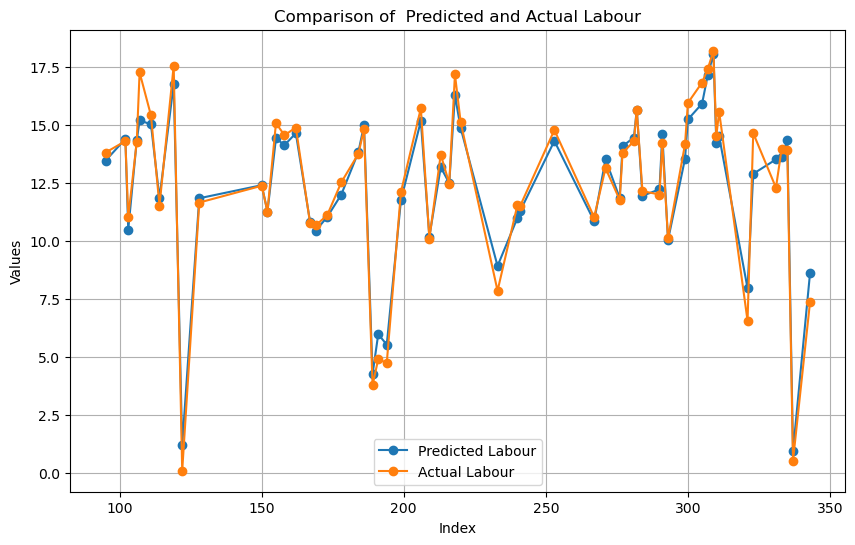

In [44]:
df = test_out[['preds', 'Calculated Labour']]

# Convert string values to numeric if necessary

df['preds'] = pd.to_numeric(df['preds'])
df['Calculated Labour'] = pd.to_numeric(df['Calculated Labour'])
plt.figure(figsize=(10, 6))


plt.plot(df['preds'], label='Predicted Labour', marker='o')
plt.plot(df['Calculated Labour'], label='Actual Labour', marker='o')

plt.title('Comparison of  Predicted and Actual Labour')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
feature_scores = pd.Series(clf1.feature_importances_, index=model_features).sort_values(ascending=False)
feature_scores

SU Manual       0.434390
FC Manual       0.401475
No of Colli     0.073770
SU OSR          0.062055
No of Pallet    0.016596
month           0.004481
day_of_month    0.003812
day_of_week     0.002808
is_holiday      0.000613
dtype: float64

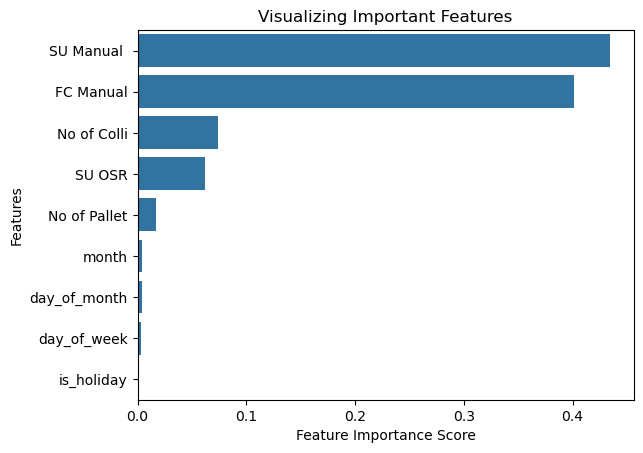

In [46]:
sns.barplot(x=feature_scores, y=feature_scores.index)



# Add labels to the graph

plt.xlabel('Feature Importance Score')

plt.ylabel('Features')



# Add title to the graph

plt.title("Visualizing Important Features")



# Visualize the graph

plt.show()



# For  the inbound Labour prediction

In [153]:
featuresi = ['No of Pallets Inbound ', ' No of Pallets InboundFrigo ',	'Number of Batches'	, 'day_of_week','day_of_month',	'month', 'Calculated Labour']

inbound =subset_in[featuresi]
inbound.head()

,No of Pallets Inbound,No of Pallets InboundFrigo,Number of Batches,day_of_week,day_of_month,month,Calculated Labour
0,156,0,30,0,1,8,3.777922
1,126,1,50,1,2,8,4.598052
2,176,33,20,2,3,8,3.859524
3,148,31,63,3,4,8,6.035931
4,172,58,55,4,5,8,6.211039


In [154]:
inbound['is_train']= np.random.uniform(0,1,len(inbound)) <= 0.80
inbound.head()

,No of Pallets Inbound,No of Pallets InboundFrigo,Number of Batches,day_of_week,day_of_month,month,Calculated Labour,is_train
0,156,0,30,0,1,8,3.777922,True
1,126,1,50,1,2,8,4.598052,True
2,176,33,20,2,3,8,3.859524,False
3,148,31,63,3,4,8,6.035931,True
4,172,58,55,4,5,8,6.211039,True


# 80 % of the inbound data as training 

In [155]:
train_in, test_in = inbound[inbound['is_train']== True], inbound[inbound['is_train']== False]
print('training length: ' ,len(train_in))
print('test length: ' ,len(test_in))

training length:  201
test length:  52


In [157]:
model_feature = inbound.columns[:6]
model_feature

Index(['No of Pallets Inbound ', ' No of Pallets InboundFrigo ',
       'Number of Batches', 'day_of_week', 'day_of_month', 'month'],
      dtype='object')

In [158]:
#  target variable labour

y_in = train_in['Calculated Labour']
len(y_in)

201

In [159]:
print(train_in[model_feature].shape)
print(y_in.shape)


(201, 6)
(201,)


In [160]:
clf = RandomForestRegressor(n_jobs=3, random_state= 0)
clf.fit(train_in[model_feature], y_in)

RandomForestRegressor(n_jobs=3, random_state=0)

In [161]:
#clf.predict(test_in[model_feature])

array([ 4.2350368 ,  4.51969697,  4.53385498,  4.89538528,  5.31887229,
        4.07254978,  4.41245887,  4.45591342,  4.47032251,  7.94674242,
        7.33913636,  4.20960823,  7.97981602,  4.87082251,  7.47007576,
        5.0905368 ,  3.78013636,  5.46500216,  7.72757792,  7.52920779,
        5.31196753,  7.68831818,  5.26725108,  5.5933961 ,  6.54134632,
        6.77387229,  7.80437446, 22.38900433,  7.10308009,  5.48058225,
        6.49809307,  4.40080736,  7.44748918,  4.47822944,  2.940829  ,
        3.65828571, 24.86771429,  5.05244805, 53.69820779,  5.25127706,
        7.09835065,  7.73184416, 33.57686797,  8.77869048,  4.66469913,
        5.05021861,  3.37989827,  6.21478788,  1.94096537,  5.0615671 ,
        5.54659307,  2.3667619 ])

In [163]:
test_in['preds'] = clf.predict(test_in[model_feature])
test_in.head()

,No of Pallets Inbound,No of Pallets InboundFrigo,Number of Batches,day_of_week,day_of_month,month,Calculated Labour,is_train,preds
2,176,33,20,2,3,8,3.859524,False,4.235037
12,148,80,35,3,18,8,4.995022,False,4.519697
18,79,30,53,4,26,8,4.546753,False,4.533855
19,182,8,38,0,29,8,4.688312,False,4.895385
23,256,2,39,4,2,9,5.616234,False,5.318872


In [164]:
# Assuming test_in is your DataFrame
test_in = test_in.drop('is_train', axis=1)
test_in.head()

,No of Pallets Inbound,No of Pallets InboundFrigo,Number of Batches,day_of_week,day_of_month,month,Calculated Labour,preds
2,176,33,20,2,3,8,3.859524,4.235037
12,148,80,35,3,18,8,4.995022,4.519697
18,79,30,53,4,26,8,4.546753,4.533855
19,182,8,38,0,29,8,4.688312,4.895385
23,256,2,39,4,2,9,5.616234,5.318872


###  Testing the accuracy of our predictions

## 5- fold cross Validation

In [165]:

from sklearn.model_selection import cross_val_score


pred_in = test_in['preds'].values.reshape(-1, 1)
actual_Labour = test_in['Calculated Labour']


#  cross validation score
scores = cross_val_score(clf, pred_in, actual_Labour, cv=5)
 
print(f"Average Accuracy: {scores.mean() * 100:.2f}%")

Average Accuracy: 83.99%


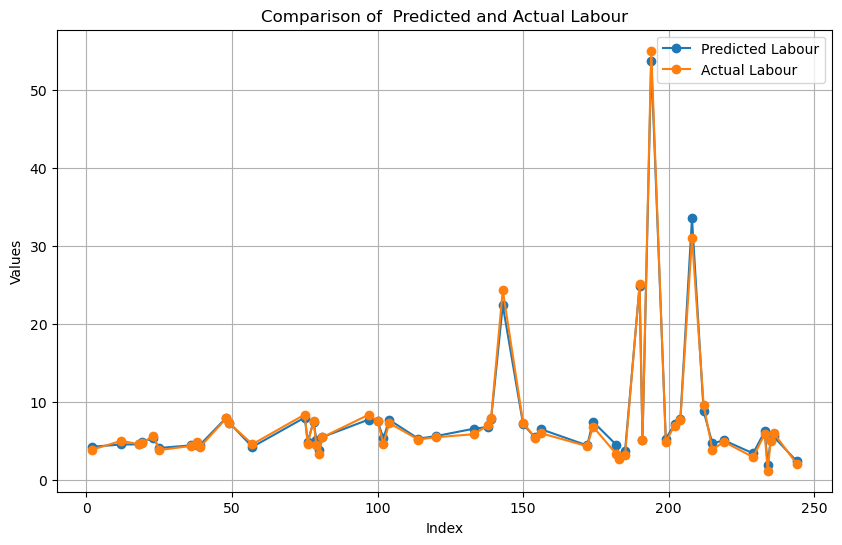

In [166]:
df = test_in[['preds', 'Calculated Labour']]

# Convert string values to numeric if necessary

df['preds'] = pd.to_numeric(df['preds'])
df['Calculated Labour'] = pd.to_numeric(df['Calculated Labour'])
plt.figure(figsize=(10, 6))


plt.plot(df['preds'], label='Predicted Labour', marker='o')
plt.plot(df['Calculated Labour'], label='Actual Labour', marker='o')

plt.title('Comparison of  Predicted and Actual Labour')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [167]:
feature_scores = pd.Series(clf.feature_importances_, index=model_feature).sort_values(ascending=False)
feature_scores

No of Pallets Inbound           0.962853
Number of Batches               0.026890
day_of_month                    0.003639
day_of_week                     0.002707
 No of Pallets InboundFrigo     0.002019
month                           0.001892
dtype: float64

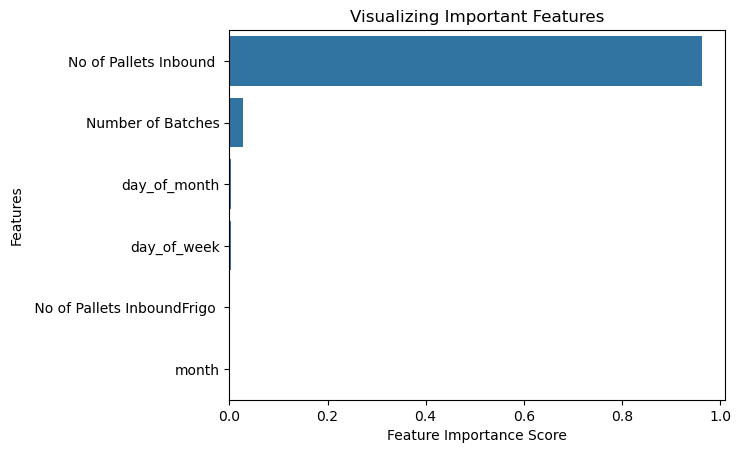

In [168]:
sns.barplot(x=feature_scores, y=feature_scores.index)



# Add labels to the graph

plt.xlabel('Feature Importance Score')

plt.ylabel('Features')



# Add title to the graph

plt.title("Visualizing Important Features")



# Visualize the graph

plt.show()

# The performance of our model for the inbound Labour using  5- fold cross validation is 85.65%

## Confusion Matrix

Not supported for continous data

##  Receiver Operating Characteristic (ROC) Curve and Area Under the Curve (AUC)

Not supported for continous data



In [169]:
test_in.to_csv('test_in_data.csv', index=False)